In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Introduction
The 


DESCRIBE PROBLEM:
classification with many, many target categories
lots of features, mixed type, many categories, many nulls - will need a bunch of cleaning

this will lead to low accuracy
best to use hierarchical classification
describe hierarchical classification plan (split options, thresholds, etc)
probably use NB classifiers for the nodes (but questionable probabilities for thresholding?) - or maybe LightGBM


# Load and clean

In [2]:
gtd_raw_df = pd.read_csv('globalterrorismdb_0718dist.csv', low_memory=False)

In [15]:
gtd_raw_df.shape

(181691, 135)

In [10]:
gtd_raw_df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [15]:
gtd_raw_df.dtypes.value_counts()

object     58
float64    55
int64      22
dtype: int64

In [18]:
print('OVER HALF NULLS:')
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if null_counts[col] > 100000:
        print(col + ":", null_counts[col])

print('\nMANY NULLS:')
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if 100000 >= null_counts[col] > 5000:
        print(col + ":", null_counts[col])

print('\nA FEW NULLS:')        
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if 5000 >= null_counts[col] > 0:
        print(col + ":", null_counts[col])
        
print('\nNO NULLS:')        
null_counts = gtd_raw_df.isnull().sum()
for col in gtd_raw_df.columns:
    if null_counts[col] == 0:
        print(col)

OVER HALF NULLS:
approxdate: 172452
resolution: 179471
location: 126196
alternative: 152680
alternative_txt: 152680
attacktype2: 175377
attacktype2_txt: 175377
attacktype3: 181263
attacktype3_txt: 181263
targtype2: 170547
targtype2_txt: 170547
targsubtype2: 171006
targsubtype2_txt: 171006
corp2: 171574
target2: 170671
natlty2: 170863
natlty2_txt: 170863
targtype3: 180515
targtype3_txt: 180515
targsubtype3: 180594
targsubtype3_txt: 180594
corp3: 180665
target3: 180516
natlty3: 180544
natlty3_txt: 180544
gsubname: 175801
gname2: 179678
gsubname2: 181531
gname3: 181367
gsubname3: 181671
motive: 131130
guncertain2: 179736
guncertain3: 181371
claimmode: 162608
claimmode_txt: 162608
claim2: 179801
claimmode2: 181075
claimmode2_txt: 181075
claim3: 181373
claimmode3: 181558
claimmode3_txt: 181558
compclaim: 176852
weaptype2: 168564
weaptype2_txt: 168564
weapsubtype2: 170149
weapsubtype2_txt: 170149
weaptype3: 179828
weaptype3_txt: 179828
weapsubtype3: 179998
weapsubtype3_txt: 179998
weaptype4:

First we'll do the general-purpose cleaning:

In [4]:
gtd_df = gtd_raw_df.copy()

# drop the 6 rows with 'specificity' nulls - these should be impossible, since 'unknown' is included
gtd_df.dropna(subset=['specificity'], inplace=True)

# 'compclaim' is corrupted: despite having 'no' and 'unknown' options, it's overwhelmingly null with no explanation
gtd_df.drop('compclaim', axis=1, inplace=True)

# for some columns, -9 purely indicates 'unknown' and is precisely the same as Nan
gtd_df['claimed'] = gtd_df.claimed.replace(-9, np.nan)
gtd_df['ransom'] = gtd_df.ransom.replace(-9, np.nan)
gtd_df['ishostkid'] = gtd_df.ishostkid.replace(-9, np.nan)
gtd_df['doubtterr'] = gtd_df.doubtterr.replace(-9, np.nan)
gtd_df['nperps'] = gtd_df.nperps.replace(-99, np.nan)
gtd_df['nperpcap'] = gtd_df.nperpcap.replace(-99, np.nan)

# 20 unknown months are entered as 0s
gtd_df['imonth'] = gtd_df.imonth.replace(0, np.nan)

# drop numerical category codes for categorical string variables (redundant)
numerical_codes = [
    'natlty1',
    'country',
    'attacktype1',
    'attacktype2',
    'attacktype3',
    'targtype1',
    'targtype2',
    'targtype3',
    'targsubtype1',
    'targsubtype2',
    'targsubtype3',
    'weaptype1',
    'weaptype2',
    'weaptype3',
    'weaptype4',
    'weapsubtype1',
    'weapsubtype2',
    'weapsubtype3',
    'weapsubtype4',
    'alternative',
    'hostkidoutcome',
    'propextent',
    'claimmode'
]
gtd_df.drop(numerical_codes, axis=1, inplace=True)

# add total_null_ct column (done after the above so num-coded categorical features aren't counted twice)
gtd_df['total_null_ct'] = gtd_df.isnull().sum(axis=1)

# since there are no iyear nulls, and only 20 imonth nulls, and day of month won't likely be useful,
# we can drop approxdate altogether:
gtd_df.drop('approxdate', axis=1, inplace=True)

# fill nulls in alternative_txt (coded alt explanation, e.g. State Actors, for doubted cases)
# with new category 'None'
gtd_df['alternative_txt'] = gtd_df['alternative_txt'].fillna('None')

# for instances with no longitude or latitude, read in the central longitude and latitude 
# of the country of occurrence (from an external datasheet), but flag as approximate
gtd_df['coordinates_are_approx'] = gtd_df.longitude.isnull()
coordinates_df = pd.read_csv('country_coordinates2.csv')[['name','latitude','longitude']]
coordinates_df.rename(columns={'name':'country_txt','latitude':'latitude2','longitude':'longitude2'}, inplace=True)
gtd_df = gtd_df.merge(coordinates_df, on='country_txt', how='left')
gtd_df['longitude'] = gtd_df.longitude.fillna(gtd_df.longitude2)
gtd_df['latitude'] = gtd_df.latitude.fillna(gtd_df.latitude2)
gtd_df.drop(['latitude2', 'longitude2'], axis=1, inplace=True)
# for reasons unclear, the one 'St. Kitts and Nevis' null won't fill even when the name is directly copied and pasted
# into this spreadsheet.  We'll manually fill it here:
gtd_df.at[59662,'latitude'] = 17.357822
gtd_df.at[59662,'longitude'] = -62.783998
gtd_df.isnull().sum().sum()

# boolean-ize and drop columns that are overwhelmingly null and have many categories:
gtd_df['has_second_attacktype'] = ~gtd_df.attacktype2_txt.isnull()
gtd_df['is_related'] = ~gtd_df.related.isnull()
gtd_df.drop(['related','attacktype2_txt', 'attacktype3_txt'], axis=1, inplace=True)

# combine nhours and ndays of hostage situation
gtd_df['nhours'] = gtd_df.nhours + gtd_df.ndays*24
gtd_df.drop('ndays', axis=1, inplace=True)

# convert hostages released to hostages unreleased so that we can fill with 0:
gtd_df['n_unreleased'] = gtd_df['nhostkid'] - gtd_df['nreleased']
gtd_df.drop('nreleased', axis=1, inplace=True)

# fill 0 for hostage-related numbers where no hostages taken
hostage_num_cols = [
    'nhours',
    'nhostkid',
    'nhostkidus',
    'ransomamt',
    'ransomamtus',
    'ransompaid',
    'ransompaidus',
    'n_unreleased'
]
gtd_df[hostage_num_cols] = gtd_df[hostage_num_cols].fillna(0)

# drop sparse & unhelpful secondary / tertiary claim info - which is almost entirely null:
empty_cols = [
    'claim2',
    'claimmode2',
    'claim3',
    'claimmode3',
    'natlty2',
    'natlty3',
    'guncertain2',
    'guncertain3'
]
gtd_df.drop(empty_cols, axis=1, inplace=True)

# fill 'none' for categorical extent of property damage (includes 'unknown' already; blanks are for no damage)
gtd_df['propextent_txt'] = gtd_df['propextent_txt'].fillna('none')

# drop all other string columns with null counts > 100K, with a few exceptions
significant_though_null_cols = ['motive', 'location', 'propcomment', 'resolution']
for col in gtd_df.select_dtypes('object').columns:
    if gtd_df[col].isnull().sum() > 100000 and col not in significant_though_null_cols:
        gtd_df.drop(col, axis=1, inplace=True)   

Then we'll do some additional cleaning for modeling purposes:

In [68]:
gtd_prepped_df = gtd_df.copy()

# *** DEALING WITH TEXT COLUMNS ***

# drop the following columns because they're long strings (unique, not categories)
# we'll save them in a separate df for later feature engineering
text_cols = [
    'summary', #  textual summary of event
    'motive', # reported motive of attack
    'weapdetail',  # additional notes on weapon
    'location', # additional notes on location
    'target1', # name of target
    'scite1', # source citation 1
    'propcomment'
]
text_df = gtd_prepped_df[text_cols]
gtd_prepped_df.drop(text_cols, axis=1, inplace=True)

# *** DEALING WITH HYPERSPECIFIC CATEGORICAL COLUMNS ***

# list categorical columns with too many distinct values for dummying (ranging 100-3000 vals)
# NOTE: 'country_txt' at 205 distinct values, is excepted because of its obvious importance
hyperspecific_cols = [
    'natlty1_txt',      # 210 distinct values, but almost entirely identical to 'country_txt'
    'provstate',        # useful, but 2855 distinct values
    'city',             # useful, but 36672 distinct values
    'targsubtype1_txt', # 112 distinct values, with dwindling tail of value counts
]
# fill their nulls with 'unknown'
for col in hyperspecific_cols:
    gtd_prepped_df[col] = gtd_prepped_df[col].fillna('Unknown')
    
# convert hyperspecific features to the X most common values (X determined by manual dropoff-analysis) or 'other'
def top_n_cats(series, n=10, keep_nulls=False):
    top_n = series.value_counts().index[:n]
    if keep_nulls:
        top_n = list(top_n) + [np.nan]
    return pd.Series([val if val in top_n else 'other' for val in series])   

hyperspecific_tups = [
    ('provstate', 15),
    ('city', 15),
    ('targsubtype1_txt', 20)
]

for tup in hyperspecific_tups:
    gtd_prepped_df[tup[0]+'_common'] = top_n_cats(gtd_prepped_df[tup[0]], n=tup[1])

# we'll save the original columns for later feature engineering etc. before dropping them
hyperspecific_df = gtd_prepped_df[hyperspecific_cols + ['gname']].copy()
gtd_prepped_df.drop(hyperspecific_cols, axis=1, inplace=True)

# *** OTHER MISCELLANEOUS ***

# fill 'weapsubtype1_txt' with 'Unknown' (only 30 categories, so no need to commonize)
gtd_prepped_df['weapsubtype1_txt'] = gtd_prepped_df['weapsubtype1_txt'].fillna('Unknown')

# 'corp1' for name of target org. is like the above columns, but it's alread encapsulated by 'targsubtype1'
# so we'll just drop it
hyperspecific_df['corp1'] = gtd_prepped_df['corp1']
gtd_prepped_df.drop('corp1', axis=1, inplace=True)

# for now we'll also drop string 'resolution' (date of resolution of extended incident) as not likely predictive;
# we could later convert it to a number-of-days interval
gtd_prepped_df.drop('resolution', axis=1, inplace=True)

And finally, we'll do some additional imputing to create a null-less version of our data (necessary for algorithms like sklearn's that can't handle nulls):

In [36]:
gtd_filled_df = gtd_prepped_df.copy()

gtd_filled_df['imonth'] = gtd_filled_df['nkill'].fillna(0)

# fill 'guncertain' with 1 (means attributed group isn't a certain attribution)
gtd_filled_df['guncertain1'] = gtd_filled_df['guncertain1'].fillna(1)

# median-impute casualties - they're only left blank if there is evidence of some,
# (so it's non-zero), but there's insufficient evidence to give a number
casualty_cols = [
    'nkill',
    'nkillus',
    'nkillter',
    'nwound',
    'nwoundus',
    'nwoundte'
]
for col in casualty_cols:
    gtd_filled_df[col] = gtd_filled_df[col].fillna(gtd_filled_df[gtd_filled_df[col] > 0][col].median())

# fill flags with 0 where unmarked probably means no:
flag_vars = ['multiple', 'claimed', 'ransom', 'doubtterr', 'ishostkid']
gtd_filled_df[flag_vars] = gtd_filled_df[flag_vars].fillna(0)

# fill propvalue with median prop damage for cases where there was prop damage
gtd_filled_df['propvalue'] = gtd_filled_df['propvalue'].fillna(gtd_filled_df[gtd_filled_df.propvalue > 0].propvalue.median())
gtd_filled_df['propvalue'] = gtd_filled_df['propvalue'] * gtd_filled_df['property'].replace(-9, 0)

# num perpetrators would be useful, but it's overwhelmingly null and there's no good way to impute
gtd_filled_df.drop(['nperps', 'nperpcap'], axis=1, inplace=True)

# confirm that we have no nulls whatsoever remaining:
gtd_filled_df.isnull().sum().sum()

0

The upshot of all this is that we now have five dataframes to work with:
- `gtd_df`: our primary, cleaned-up dataframe (61 columns)
- `gtd_prepped_df`: a version of the main dataframe prepped for general modeling purposes
- `gtd_filled_df`: a version of the prepped dataframe with all nulls imputed or feature-dropped (59 columns)
- `text_df`: columns with long, unique text content for later processing (8 columns)
- `hyperspecific_df`: columns with too many categories for dummying that could be of use later (3 columns)

Note that all of these versions have the same number of examples in the same order.  This means that we can easily feature-engineer and concatenate later as needed.

# Exploring the Data

NOTE: `gname` (group name), representing the name of the group that perpetrated the attack, is our target variable.

In [19]:
all_groups = gtd_df.gname.value_counts().index[1:] # starting at 1 omits 'Unknown'
num_groups = len(all_groups)
num_singletons = sum(gtd_df.gname.value_counts()==1)
singleton_groups = all_groups[-num_singletons:]
non_singleton_groups = all_groups[:num_singletons]

# calculate number of attacks where we don't know the perpetrating group
pct_unattributed = round(sum( gtd_df.gname=='Unknown') / len(gtd_df.gname) *100)

print("Number of total groups:", num_groups) # -1 because 'Unknown' is a category
print("Number of groups with only one attributed attack:", num_singletons)
print("Number of groups with at least two attributed attacks:", sum(gtd_df.gname.value_counts()>1) -1)
print("Number of groups with at least ten attributed attacks:", sum(gtd_df.gname.value_counts()>9) -1)
print("\nNumber of unattributed attacks:", 
      sum(gtd_df.gname=='Unknown'), 
      "({}% of dataset)".format(pct_unattributed) )

Number of total groups: 3536
Number of groups with only one attributed attack: 1711
Number of groups with at least two attributed attacks: 1825
Number of groups with at least ten attributed attacks: 591

Number of unattributed attacks: 82780 (46% of dataset)


In [20]:
print(gtd_df.gname.value_counts()[1:11])

Taliban                                             7477
Islamic State of Iraq and the Levant (ISIL)         5613
Shining Path (SL)                                   4555
Farabundo Marti National Liberation Front (FMLN)    3351
Al-Shabaab                                          3287
New People's Army (NPA)                             2772
Irish Republican Army (IRA)                         2671
Revolutionary Armed Forces of Colombia (FARC)       2487
Boko Haram                                          2418
Kurdistan Workers' Party (PKK)                      2310
Name: gname, dtype: int64


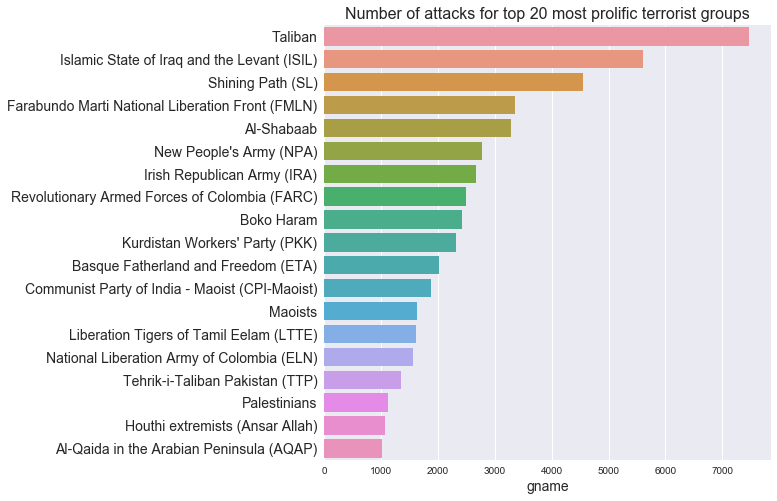

In [176]:
plt.rc('axes', titlesize=16)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)

plt.figure(figsize=(8,8))
y = gtd_df.gname.value_counts().index[1:20]
x = gtd_df.gname.value_counts()[1:20]
sns.barplot(x, y)
plt.title("Number of attacks for top 20 most prolific terrorist groups")
plt.show()

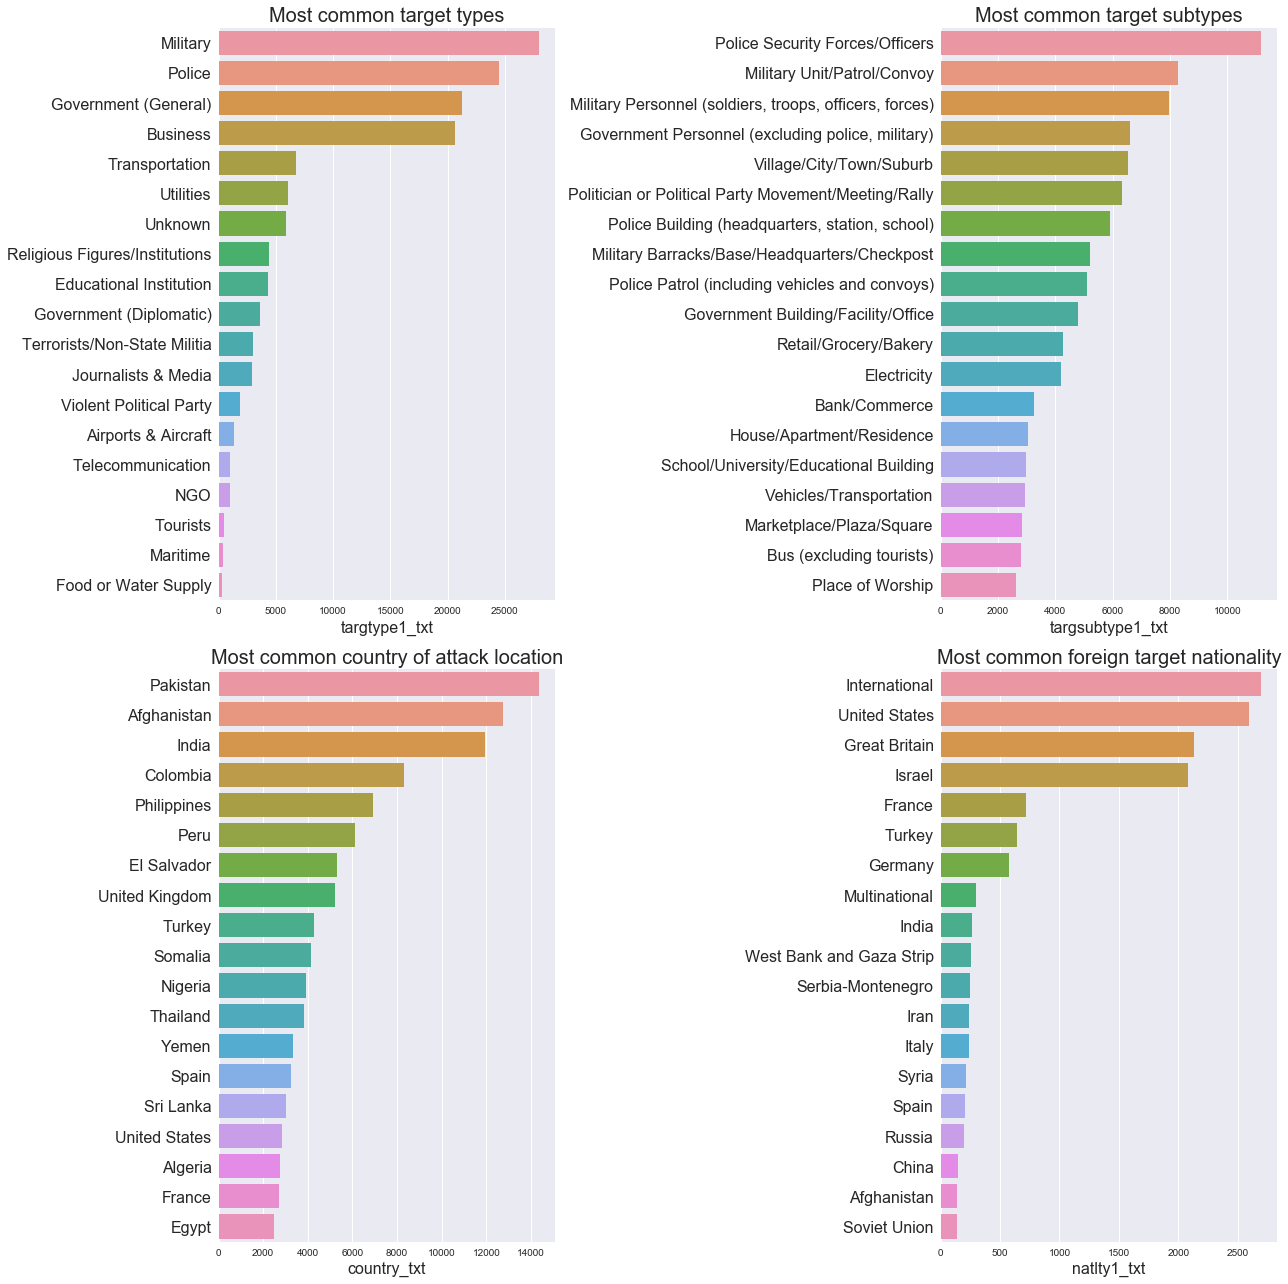

In [326]:
plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.title('Most common target types')
y = gtd_df.targtype1_txt.value_counts().index[1:20]
x = gtd_df.targtype1_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.subplot(222)
plt.title('Most common target subtypes')
y = hyperspecific_df.targsubtype1_txt.value_counts().index[1:20]
x = hyperspecific_df.targsubtype1_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.subplot(223)
plt.title('Most common country of attack location')
y = gtd_df.country_txt.value_counts().index[1:20]
x = gtd_df.country_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.subplot(224)
plt.title('Most common foreign target nationality')
y = gtd_df[gtd_df.natlty1_txt!=gtd_df.country_txt].natlty1_txt.value_counts().index[1:20]
x = gtd_df[gtd_df.natlty1_txt!=gtd_df.country_txt].natlty1_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.tight_layout()
plt.show()

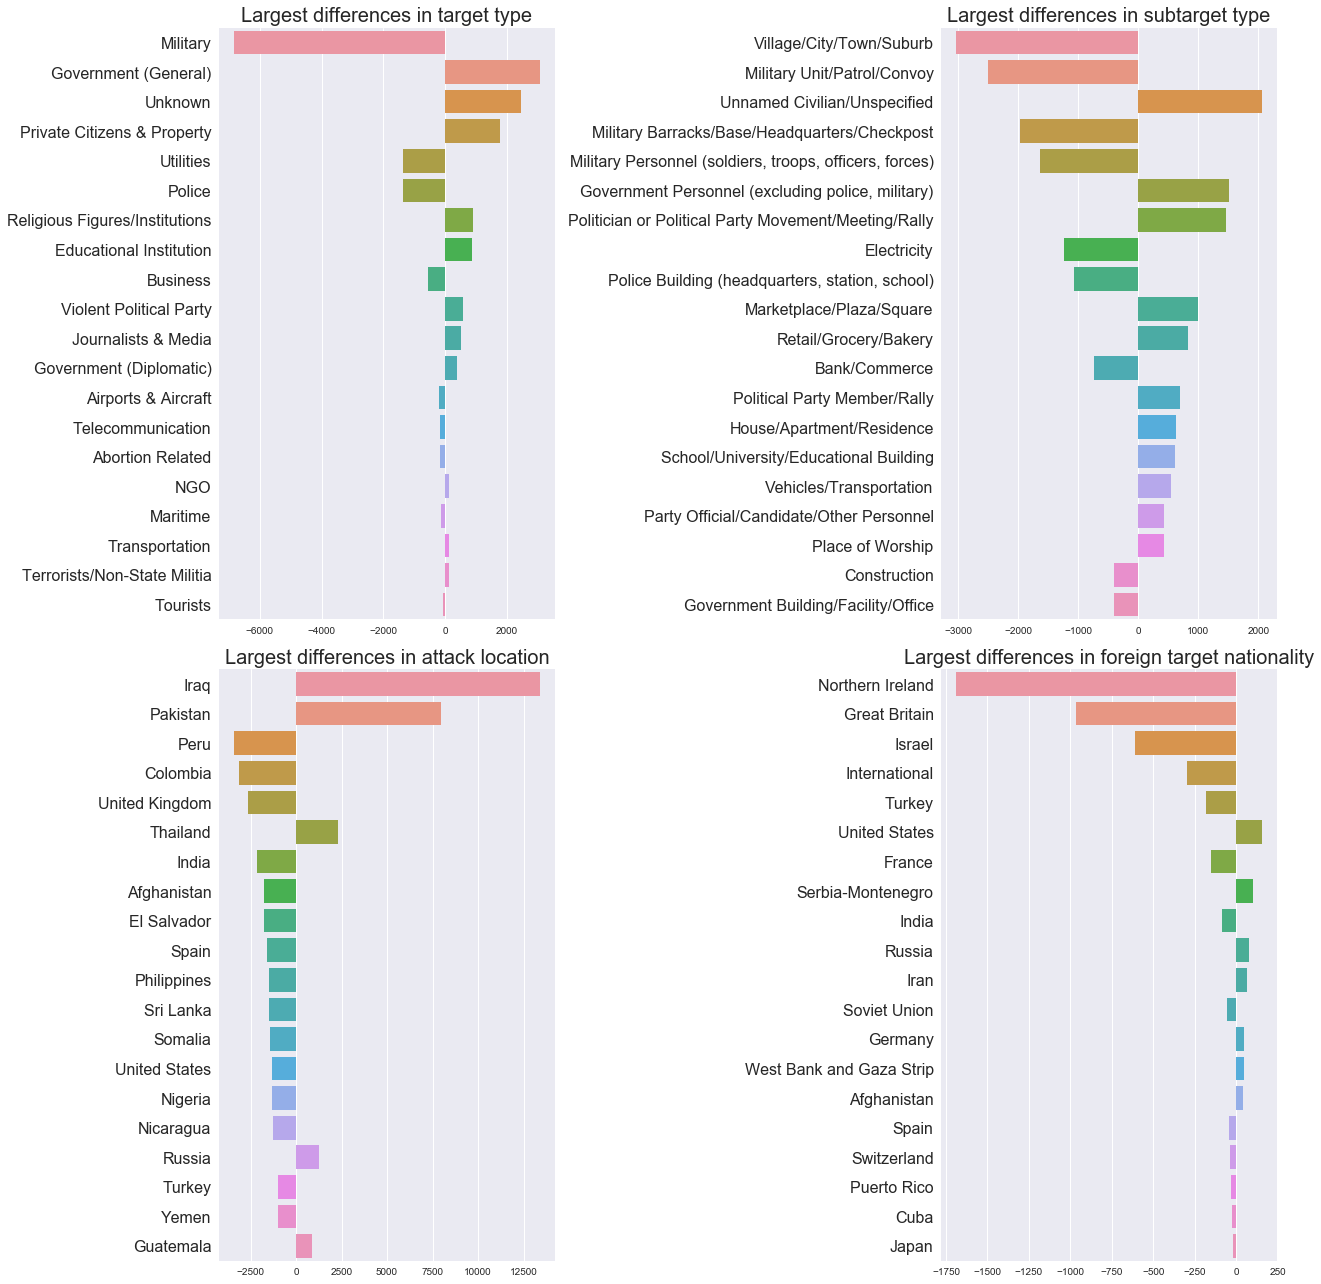

In [330]:
unattr_ratio = sum(gtd_df.gname=='Unknown')/sum(gtd_df.gname!="Unknown")
attributed_df = gtd_df[gtd_df.gname!='Unknown']
unattributed_df = gtd_df[gtd_df.gname=='Unknown']
hyperspecific_attr = hyperspecific_df[hyperspecific_df.gname!='Unknown']
hyperspecific_unattr = hyperspecific_df[hyperspecific_df.gname=='Unknown']

plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.title('Largest differences in target type')
cat_diff_tups = []
attr_val_counts = attributed_df.sample(frac=unattr_ratio).targtype1_txt.value_counts()
unattr_val_counts = unattributed_df.targtype1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(222)
plt.title('Largest differences in subtarget type')
cat_diff_tups = []
attr_val_counts = hyperspecific_attr.sample(frac=unattr_ratio).targsubtype1_txt.value_counts()
unattr_val_counts = hyperspecific_unattr.targsubtype1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(223)
plt.title('Largest differences in attack location')
cat_diff_tups = []
attr_val_counts = attributed_df.sample(frac=unattr_ratio).country_txt.value_counts()
unattr_val_counts = unattributed_df.country_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.subplot(224)
plt.title('Largest differences in foreign target nationality')
cat_diff_tups = []
attr_val_counts = attributed_df[attributed_df.natlty1_txt!=attributed_df.country_txt].sample(frac=unattr_ratio).natlty1_txt.value_counts()
unattr_val_counts = unattributed_df[unattributed_df.natlty1_txt!=unattributed_df.country_txt].natlty1_txt.value_counts()
for val in attr_val_counts.index:
    if val in unattr_val_counts.index:
        cat_diff_tups.append( (val, unattr_val_counts[val] - attr_val_counts[val]) )
cat_diff_tups = sorted(cat_diff_tups, key=lambda x: -abs(x[1]))
y = [tup[0] for tup in cat_diff_tups[:20]]
x = [tup[1] for tup in cat_diff_tups[:20]]
sns.barplot(x, y)

plt.tight_layout()
plt.show()

In [ ]:
plt.rc('axes', titlesize=20)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=16)

plt.figure(figsize=(18, 18))

plt.subplot(221)
plt.title('Most common target types')
y = gtd_df.targtype1_txt.value_counts().index[1:20]
x = gtd_df.targtype1_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.subplot(222)
plt.title('Most common target subtypes')
y = hyperspecific_df.targsubtype1_txt.value_counts().index[1:20]
x = hyperspecific_df.targsubtype1_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.subplot(223)
plt.title('Most common target nationality')
y = gtd_df.natlty1_txt.value_counts().index[1:20]
x = gtd_df.natlty1_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.subplot(224)
plt.title('Most common country of attack location')
y = gtd_df.country_txt.value_counts().index[1:20]
x = gtd_df.country_txt.value_counts()[1:20]
sns.barplot(x, y)

plt.tight_layout()
plt.show()

In [187]:
# most common number of attacks perpetrated by each group:
pd.Series(gtd_df[gtd_df.gname!='Unknown'].gname.value_counts()).value_counts()[:15]

1     1711
2      482
3      265
4      142
5      112
6       82
7       60
8       52
9       39
10      36
11      26
12      22
14      21
13      20
17      20
Name: gname, dtype: int64

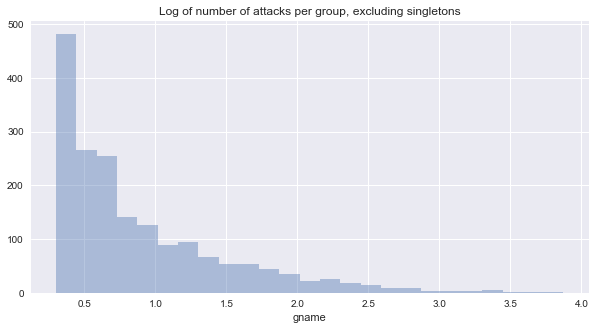

In [120]:
plt.figure(figsize=(10,5))
sns.distplot(np.log10(gtd_df.gname.value_counts()[1:1826]), kde=False)
plt.title("Log of number of attacks per group, excluding singletons")
plt.show()

# Feature engineering



In [70]:
non_domestic_target = [gtd_df.natlty1_txt[i] if gtd_df.natlty1_txt[i] != gtd_df.country_txt[i] else np.nan \
    for i in range(len(gtd_df.natlty1_txt))]
gtd_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=True)
gtd_prepped_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=True)
gtd_filled_df['non_domestic_target'] = top_n_cats(pd.Series(non_domestic_target), n=30, keep_nulls=False)

In [ ]:
multinomial_NB

'city' --> city population, GDP/capita, or something?

for orgs:
- widespreadness of location (std and range of location?)
- number of 
do something with ‘related’?


For later:
- try adding in GDP, GDP/capita for each country from external source
- try adding population of city for each city from external source

### Feature reduction with GLRM:

Because we have many features, we may want a feature reduction algorithm to allow for more complex clustering algorithms that would be unfeasible on a 70+ feature dataset with 100,000 examples. We also want this featureset to be null-less so we can use sklearn and other non-null-handling libraries.  This algorithm should ideally be able to handle different types of data, including numerical, binary, and categorical.

Probably the best single algorithm that can fulfill all of these needs is Generalized Low-Rank Models. GLRM uses alternating minimization with customizable-by-column cost functions to allow for a PCA- or NNMF-like matrix factorization across various data types. The reduced dataset is null-less and lower-rank than the original. We'll try this here with the number of reduced features set to 30.

#### General-purpose GLRM:

In [168]:
# Load the H2O library and start up the H2O cluster locally on my machine
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,19 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,2 months and 20 days
H2O cluster name:,garrettfiddler
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [169]:
glrmodel_20 = H2OGeneralizedLowRankEstimator(
                                       k=20,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       #loss_by_col=[loss_by_col[c] for c in khous_run.columns], 
                                       impute_original=True)

In [164]:
# note: using gtd_prepped_df rather than the full gtd_df here
# because the latter creates a strange nullPointerException in Java 
type_conversions = {
    np.dtype('float64'):'real',
    np.dtype('int64'):'int',
    np.dtype('bool'):'enum',
    np.dtype('object'):'enum',
}

glrm_column_types = {}
coltypes = gtd_filled_df.drop('gname', axis=1).dtypes
for col in gtd_filled_df.drop('gname', axis=1).columns:
    glrm_column_types[col] = type_conversions[coltypes[col]]

In [170]:
gtd_h2 = h2o.H2OFrame(gtd_filled_df.drop('gname', axis=1), column_types=glrm_column_types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [171]:
start = time()
glrmodel_20.train(training_frame=gtd_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 21.8 minutes


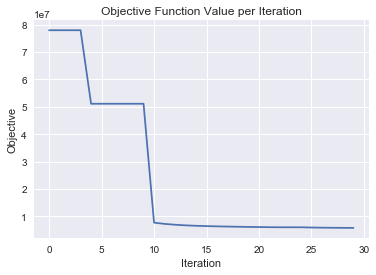

In [172]:
model_score = glrmodel_20.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [173]:
model = glrmodel_20._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_20_df = X.as_data_frame()

print('Projected shape:', glrm_20_df.shape)

Projected shape: (181685, 20)


In [174]:
glrm_20_df.to_csv('glrm_20.csv')

#### GLRM for visualization:

In [159]:
glrmodel_vis = H2OGeneralizedLowRankEstimator(
                                       k=2,
                                       seed=11,
                                       transform="STANDARDIZE",
                                       regularization_x="None", 
                                       regularization_y="None",
                                       init='SVD',
                                       max_iterations=30, 
                                       multi_loss='categorical',
                                       impute_original=True)

In [160]:
# note: used gtd_prepped_df for this one
start = time()
glrmodel_vis.train(training_frame=gtd_h2)
print('elapsed time:', round((time()-start)/60, 1), "minutes")

glrm Model Build progress: |██████████████████████████████████████████████| 100%
elapsed time: 3.0 minutes


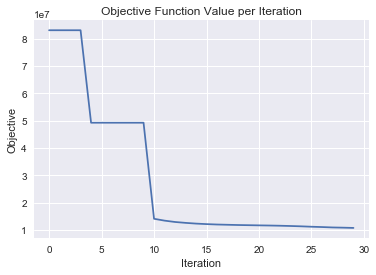

In [161]:
model_score = glrmodel_vis.score_history()
plt.xlabel("Iteration")
plt.ylabel("Objective")
plt.title("Objective Function Value per Iteration")
plt.plot(model_score["iterations"], model_score["objective"])
plt.show()

In [162]:
model = glrmodel_vis._model_json
model_out = model['output']
# num_archs = glrmodel_5.params['k']['actual']
archs_df = model_out["archetypes"].as_data_frame()
archs = np.array(archs_df)
X = h2o.get_frame(model_out['representation_name'])
glrm_vis_df = X.as_data_frame()

print('Projected shape:', glrm_vis_df.shape)

Projected shape: (181685, 2)


In [166]:
glrm_vis_df.to_csv('glrm_vis.csv')

# Initial model trials

Before we start building a hierarchical classification model, it makes sense to try flat classification just as a benchmark.  This will help us see what we're working with.  First, we'll try using one or two basic classifiers (Logistic Regression and Naive Bayes) and then a more advanced one (LightGBM). The reasoning here:
- Logistic Regression is the canonical basic linear classification algorithm (though it's unlikely to perform well given the non-linearity of our data), and with stochastic gradient descent, it's also fast (which is important given how many categories we have)
- Naive Bayes is the canonical non-linear classification algorithm, and it's very fast.  Given the nature of our data, I wouldn't be surprised if it scores as well as anything here.
- LightGBM generally scores as well as any of the gradient boosted tree classifiers, and it's significantly faster

For the sake of time, we'll start with training on only the top 100 groups, all of which are recorded to have perpetrated at least 136 attacks.

### try NB first, check time
### if possible, start with NB on all non-singletons

In [98]:
X_df = pd.get_dummies(gtd_prepped_df.drop('gname', axis=1))

In [99]:
X_df.shape

(181685, 460)

In [ ]:
all_groups = gtd_df.gname.value_counts().index[1:] # starting at 1 omits 'Unknown'
num_groups = len(all_groups)
num_singletons = sum(gtd_df.gname.value_counts()==1)
singleton_groups = all_groups[-num_singletons:]
non_singleton_groups = all_groups[:num_singletons]

# calculate number of attacks where we don't know the perpetrating group
pct_unattributed = round(sum( gtd_df.gname=='Unknown') / len(gtd_df.gname) *100)

print("Number of total groups:", num_groups) # -1 because 'Unknown' is a category
print("Number of groups with only one attributed attack:", num_singletons)
print("Number of groups with at least two attributed attacks:", sum(gtd_df.gname.value_counts()>1) -1)
print("Number of groups with at least ten attributed attacks:", sum(gtd_df.gname.value_counts()>9) -1)

In [84]:
from time import time
from sklearn.model_selection import train_test_split
import warnings

def quick_test_model(model, X_set, y):
    # NOTE: I'm using accuracy as the sole metric here because it's the same as either micro or macro f1-score
    # for cases where every example belongs to one and only one category
    
    warnings.filterwarnings(action='ignore', category=DeprecationWarning) # arises with current lightGBM + numpy
    
    start = time()
    X_train, X_test, y_train, y_test = train_test_split(X_set, y, test_size=1/3)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_accuracy = round(sum(y_pred_train==y_train)/len(y_train), 3)
    test_accuracy = round(sum(y_pred_test==y_test)/len(y_test), 3)
    
    print("  train accuracy:", train_accuracy)
    print("  test accuracy:", test_accuracy)
    print("elapsed time:", round((time()-start)/60, 1), 'minutes')

In [279]:
from lightgbm import LGBMClassifier

lgbmc_basic_params = {
    'class_weights':'balanced', 
    'objective':'multiclass', 
    'metric':'multi_logloss', 
    'num_class':20,
    'n_estimators':10,
    'min_data_in_leaf':20}

interval_tuples = [
    (1,21),
    (101, 121),
    (1,101),
    (101, 201),
    (101, 301),
    (101, 501),
    (101, 1001)
]

for tup in interval_tuples:
    
    next_20_groups = gtd_df.gname.value_counts()[tup[0]:tup[1]].index
    total_attacks = sum(gtd_df.gname.value_counts()[tup[0]:tup[1]])
    attacks_per_group = int(round(np.mean(gtd_df.gname.value_counts()[tup[0]:tup[1]])))

    next_20_df = gtd_df[gtd_df.gname.isin(next_20_groups)]
    X_temp_df = pd.get_dummies(next_20_df.drop('gname', axis=1))
    y = next_20_df.gname

    lgbmc = LGBMClassifier(**lgbmc_basic_params)
    # Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    print("\nPrediction over groups #{}-{}:\n  (total attacks = {}; average attacks per group = {})".format(
        tup[0], 
        tup[1]-1, 
        total_attacks,
        attacks_per_group))
    quick_test_model(lgbmc, X_temp_df, y)


Prediction over groups #1-20:
  (total attacks = 51092; average attacks per group = 2555)
  train accuracy: 0.988
  test accuracy: 0.985
elapsed time: 3.1 minutes

Prediction over groups #101-120:
  (total attacks = 2377; average attacks per group = 119)
  train accuracy: 0.98
  test accuracy: 0.97
elapsed time: 0.0 minutes

Prediction over groups #201-220:
  (total attacks = 993; average attacks per group = 50)
  train accuracy: 0.961
  test accuracy: 0.885
elapsed time: 0.0 minutes

Prediction over groups #401-420:
  (total attacks = 364; average attacks per group = 18)
  train accuracy: 0.988
  test accuracy: 0.91
elapsed time: 0.0 minutes

Prediction over groups #1-100:
  (total attacks = 75524; average attacks per group = 755)
  train accuracy: 0.963
  test accuracy: 0.932
elapsed time: 8.8 minutes

Prediction over groups #101-200:
  (total attacks = 8302; average attacks per group = 83)
  train accuracy: 0.957
  test accuracy: 0.885
elapsed time: 0.2 minutes

Prediction over gro

In [104]:
top_20 = gtd_df.gname.value_counts().index[1:21]
is_top_20 = gtd_df.gname.isin(top_20)
next_30 = gtd_df.gname.value_counts().index[21:51]
is_next_30 = gtd_df.gname.isin(next_30)

print(
    '''Predictive accuracy for whether attack is by one of the top 20
most prolific perpetrating groups:''')
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_top_20)

print(
    '''\nPredictive accuracy for whether attack is by one of the top 50 (but not top 20)
most prolific perpetrating groups:''')
quick_test_model(LGBMClassifier(class_weight='balanced'), X_df, is_next_30)

Predictive accuracy for whether attack is by one of the top 20
most prolific perpetrating groups:
  train accuracy: 0.964
  test accuracy: 0.962
elapsed time: 0.3 minutes

Predictive accuracy for whether attack is by one of the top 50 (but not top 20)
most prolific perpetrating groups:
  train accuracy: 0.926
  test accuracy: 0.925
elapsed time: 0.3 minutes


In [106]:
for tup in [(100, 500)]:
    next_20_groups = gtd_prepped_df.gname.value_counts()[tup[0]:tup[1]].index
    total_attacks = sum(gtd_prepped_df.gname.value_counts()[tup[0]:tup[1]])
    attacks_per_group = int(round(np.mean(gtd_prepped_df.gname.value_counts()[tup[0]:tup[1]])))

    next_20_df = gtd_prepped_df[gtd_prepped_df.gname.isin(next_20_groups)]
    X_temp_df = pd.get_dummies(next_20_df.drop('gname', axis=1))
    y = next_20_df.gname

    lgbmc = LGBMClassifier(**lgbmc_basic_params)
    # Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    print("\nPrediction over groups #{}-{}:\n  (total attacks = {}; average attacks per group = {})".format(
        tup[0], 
        tup[1]-1, 
        total_attacks,
        attacks_per_group))
    quick_test_model(lgbmc, X_temp_df, y)


Prediction over groups #100-499:
  (total attacks = 16229; average attacks per group = 41)
  train accuracy: 0.059
  test accuracy: 0.052
elapsed time: 0.5 minutes


In [107]:
# again, but with the full dataset (instead of 'prepped' which reduces the number of dummy cols:
for tup in [(100, 500)]:
    next_20_groups = gtd_df.gname.value_counts()[tup[0]:tup[1]].index
    total_attacks = sum(gtd_df.gname.value_counts()[tup[0]:tup[1]])
    attacks_per_group = int(round(np.mean(gtd_df.gname.value_counts()[tup[0]:tup[1]])))

    next_20_df = gtd_df[gtd_df.gname.isin(next_20_groups)]
    X_temp_df = pd.get_dummies(next_20_df.drop('gname', axis=1))
    y = next_20_df.gname

    lgbmc = LGBMClassifier(**lgbmc_basic_params)
    # Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    print("\nPrediction over groups #{}-{}:\n  (total attacks = {}; average attacks per group = {})".format(
        tup[0], 
        tup[1]-1, 
        total_attacks,
        attacks_per_group))
    quick_test_model(lgbmc, X_temp_df, y)


Prediction over groups #100-499:
  (total attacks = 16229; average attacks per group = 41)
  train accuracy: 0.078
  test accuracy: 0.062
elapsed time: 3.9 minutes


In [332]:
# over 1000 groups:
for tup in [(1, 1000)]:
    next_20_groups = gtd_prepped_df.gname.value_counts()[tup[0]:tup[1]].index
    total_attacks = sum(gtd_prepped_df.gname.value_counts()[tup[0]:tup[1]])
    attacks_per_group = int(round(np.mean(gtd_prepped_df.gname.value_counts()[tup[0]:tup[1]])))

    next_20_df = gtd_prepped_df[gtd_prepped_df.gname.isin(next_20_groups)]
    X_temp_df = pd.get_dummies(next_20_df.drop('gname', axis=1))
    y = next_20_df.gname

    lgbmc = LGBMClassifier(**lgbmc_basic_params)
    # Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems
    print("\nPrediction over groups #{}-{}:\n  (total attacks = {}; average attacks per group = {})".format(
        tup[0], 
        tup[1]-1, 
        total_attacks,
        attacks_per_group))
    quick_test_model(lgbmc, X_temp_df, y)


Prediction over groups #1-999:
  (total attacks = 95119; average attacks per group = 95)
  train accuracy: 0.201
  test accuracy: 0.207
elapsed time: 48.3 minutes


# Scratch

In [ ]:
test_df = pd.DataFrame()
test_df['a'] = [1,2,3,4]
test_df['b'] = [5,6,7,8]
test_df['c'] = ['q','r','s','t']
test_df

In [300]:
# show countries with null latitudes:
gtd_filled_df[gtd_filled_df.longitude.isnull()].gname.isnull().sum()

0

In [271]:
# search for country:
countries = np.unique([c for c in gtd_df.country_txt.values if "Cocos" in c])
gtd_df.country_txt.value_counts()[countries]

Series([], Name: country_txt, dtype: int64)

In [48]:
# show remaining null counts after filling everything but long/lat:
nulls = gtd_filled_df.isnull().sum()
for col in gtd_filled_df.columns:
    if nulls[col] > 0:
        print(col, nulls[col])

latitude 4550
longitude 4551


In [ ]:
# CORE COLUMNS - most likely to be determinative of the group responsible
core_cols = [
    'iyear'
    'country_txt'
    'city'
    'latitude'
    'longitude'
    'suicide'
    'natlty1_txt'
    'attacktype1'
    'targtype1_txt'
    'targsubtype1_txt'
    'weaptype1_txt'
    'weapsubtype1_txt'
    'ishostkid'
    'nhostkid'
    'INT_LOG'
    'INT_IDEO'
    'INT_MISC'
]